In [1]:
import os
import re
import zipfile

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from PIL import Image
import ast
import json
from glob import glob
import cv2
import time

In [139]:
path_pedestrian = '/home/mvlab/Downloads/dataset/통영/'
class_names = ['bg', '"water"', '"waterf"', '"land"', '"animal"']
names = ['fn','cname','id', 'x0', 'y0', 'w', 'h']
max_data_m = 10000
num_classes = 80
edgecolors = np.random.rand(num_classes, 3) 
edgecolors = np.minimum(edgecolors+0.1, 1.0)

os.path.isdir(path_pedestrian)

True

In [61]:
paths_avi = glob(path_pedestrian+'*.avi')
paths_txt = glob(path_pedestrian+'*.txt')
paths_img = glob(path_pedestrian+'*/*')
len(paths_avi), len(paths_txt), len(paths_img)

(1, 1, 4400)

### video label load

In [62]:
df = pd.read_csv(paths_txt[0], header=None, names=names)
df.shape

(1327, 7)

In [70]:
df

fn   cname  id   x0   y0    w    h  \
0     2322  person   0  708  832  114  244   
1     2323  person   0  710  824  114  244   
2     2324  person   0  708  818  114  244   
3     2325  person   0  709  817  114  244   
4     2326  person   0  708  812  114  244   
...    ...     ...  ..  ...  ...  ...  ...   
1322  3644  person   0  748  276   18   38   
1323  3645  person   0  749  277   18   38   
1324  3646  person   0  749  277   18   38   
1325  3647  person   0  748  276   19   40   
1326  3648  person   0  749  275   19   40   

                                                   path  
0     /home/mvlab/Downloads/dataset/통영/미수_스마트시티_통영대교...  
1     /home/mvlab/Downloads/dataset/통영/미수_스마트시티_통영대교...  
2     /home/mvlab/Downloads/dataset/통영/미수_스마트시티_통영대교...  
3     /home/mvlab/Downloads/dataset/통영/미수_스마트시티_통영대교...  
4     /home/mvlab/Downloads/dataset/통영/미수_스마트시티_통영대교...  
...                                                 ...  
1322  /home/mvlab/Downloads/dataset/통영/미수_스마트시티_통영대교...  
1323  /home/mvlab/Downloads/dataset/통영/미수_스마트시티_통영대교...  
1324  /home/mvlab/Downloads/dataset/통영/미수_스마트시티_통영대교...  
1325  /home/mvlab/Downloads/dataset/통영/미수_스마트시티_통영대교...  
1326  /home/mvlab/Downloads/dataset/통영/미수_스마트시티_통영대교...  

[1327 rows x 8 columns]

In [64]:
df.isna().sum().sum()

0

In [66]:
def set_frame_path(df, paths_img):
    frame = df['fn'].values
    
    file_name_dict = dict()
    
    for path_img in paths_img:
        file_name = path_img.split(os.sep)[-1]
        file_name = file_name.split('.')[0]
        file_name = int(file_name)
        file_name_dict[file_name] = path_img
            
    print('file_name_dict', len(file_name_dict)) 
    
    list_path = []
            
    for fr in frame:
        if fr in file_name_dict.keys():
            list_path.append(file_name_dict[fr])
        else:
            list_path.append(None)
            
    df['path'] = list_path    

set_frame_path(df, paths_img)

file_name_dict 4400


### image label load

In [114]:
path_cut = path_pedestrian + 'bridge_img_01/'
path_cut_label = glob(path_cut + '*.txt')
path_cut, os.path.isdir(path_cut), len(path_cut_label)

('/home/mvlab/Downloads/dataset/통영/bridge_img_01/', True, 1)

In [115]:
path_cut_csv = path_cut_label[0]
path_cut_csv

'/home/mvlab/Downloads/dataset/통영/bridge_img_01/image_label.txt'

In [122]:
names = ['path','cname','id', 'x0', 'y0', 'w', 'h']
df_cut = pd.read_csv(path_cut_csv, names=names)
df_cut['path'] = path_cut + df_cut['path']
df_cut.shape

(409, 7)

In [123]:
df_cut

path   cname  id    x0   y0  \
0    /home/mvlab/Downloads/dataset/통영/bridge_img_01...  person  -1  1064  549   
1    /home/mvlab/Downloads/dataset/통영/bridge_img_01...  person  -1  1087  550   
2    /home/mvlab/Downloads/dataset/통영/bridge_img_01...  person  -1  1061  573   
3    /home/mvlab/Downloads/dataset/통영/bridge_img_01...  person  -1  1081  450   
4    /home/mvlab/Downloads/dataset/통영/bridge_img_01...  person  -1  1080  463   
..                                                 ...     ...  ..   ...  ...   
404  /home/mvlab/Downloads/dataset/통영/bridge_img_01...  person  -1  1075  678   
405  /home/mvlab/Downloads/dataset/통영/bridge_img_01...  person  -1  1071  690   
406  /home/mvlab/Downloads/dataset/통영/bridge_img_01...  person  -1  1078  716   
407  /home/mvlab/Downloads/dataset/통영/bridge_img_01...  person  -1  1076  742   
408  /home/mvlab/Downloads/dataset/통영/bridge_img_01...  person  -1  1029  868   

      w    h  
0    22   56  
1    26   61  
2    22   54  
3    22   26  
4    20   50  
..   ..  ...  
404  45  114  
405  51  130  
406  61  135  
407  64  142  
408  76  204  

[409 rows x 7 columns]

In [125]:
df = pd.concat((df, df_cut), axis=0)

In [126]:
annotation = dict()
for i in range(len(df)):
    row = df.iloc[i].values
    fn, cname, iden, x0, y0, w, h, path = row
    x1 = x0 + w
    y1 = y0 + h
    if i%100==0:
        print(i, fn, cname, iden, x0, y0, x1, y1)
    fn = str(fn)
    cls = 3 # land 
    bbox = [cls, x0, y0, x1, y1]
    
    path_image = path
    if path_image in annotation.keys():
        annotation[path_image].extend(bbox)
    else:
        annotation[path_image] = bbox        

0 2322.0 person 0 708 832 822 1076
100 2422.0 person 0 695 635 776 808
200 2522.0 person 0 733 524 800 667
300 2622.0 person 0 747 447 805 570
400 2722.0 person 0 740 409 787 510
500 2822.0 person 0 746 377 787 465
600 2922.0 person 0 739 353 773 425
700 3022.0 person 0 738 331 769 396
800 3122.0 person 0 741 315 769 374
900 3222.0 person 0 735 301 761 357
1000 3322.0 person 0 751 294 774 343
1100 3422.0 person 0 741 282 764 331
1200 3522.0 person 0 744 277 764 319
1300 3622.0 person 0 748 270 767 310
1400 nan person -1 701 561 729 627
1500 nan person -1 1066 539 1091 603
1600 nan person -1 1034 875 1122 1066
1700 nan person -1 1083 410 1103 446


In [96]:
len(annotation)

1327

In [127]:
input_list = []
bbox_list = []
path_list = []
for path_image in annotation:
    cls_bbox = annotation[path_image]
    cls_bbox = np.array(cls_bbox).reshape([-1, 5])
    cls = cls_bbox[:, 0:1]
    bbox = np.array(cls_bbox[:, 1:])
   
    if os.path.isfile(path_image):
        img = Image.open(path_image)    
        scale = np.array((img.width, img.height, img.width, img.height))
        scale = np.reshape(scale, (1, 4))
       
        #print(key, cls, cls_bbox.dtype, cls_bbox, 'wh',img.width, img.height)
        img_arr = np.array(img)        
        bbox_norm = bbox.astype(np.float) / scale.astype(np.float)
        cls_bbox_norm = np.concatenate((cls, bbox_norm), axis=1)

        input_list.append(img_arr)
        bbox_list.append(cls_bbox_norm)
        path_list.append(path_image)
        if len(input_list)%100==0:        
            print(len(annotation), len(input_list), len(bbox_list))   
        if len(input_list) > max_data_m:
            break
    else:
        print('not exist', path_image)

print(len(input_list), len(bbox_list))

1530 100 100
1530 200 200
1530 300 300
1530 400 400
1530 500 500
1530 600 600
1530 700 700
1530 800 800
1530 900 900
1530 1000 1000
1530 1100 1100
1530 1200 1200
1530 1300 1300
1530 1400 1400
1530 1500 1500
1530 1530


In [134]:
img_w = 1920
bbox = np.concatenate(bbox_list, 0)
bbox_w = (bbox[:, 3] - bbox[:, 1]) * img_w
bbox.shape, np.min(bbox_w), np.max(bbox_w), np.mean(bbox_w)

((1736, 5), 9.999999999999858, 123.99999999999999, 38.066820276497694)

(array([378., 626., 233., 162.,  89., 126.,  46.,  41.,  20.,  15.]),
 array([ 10. ,  21.4,  32.8,  44.2,  55.6,  67. ,  78.4,  89.8, 101.2,
        112.6, 124. ]),
 <BarContainer object of 10 artists>)

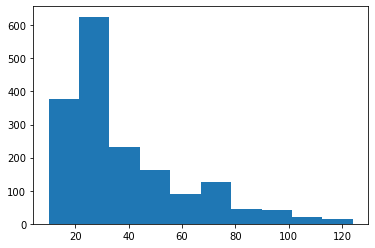

In [135]:
plt.hist(bbox_w)

In [136]:
def visualize_detections_simple(
    image, boxes, classes, figsize=(12, 12), linewidth=1, color=[0, 0, 1]
):
    """Visualize Detections"""
    image = np.array(image, dtype=np.uint8)    
    
    img_h, img_w, img_c = image.shape
    
    #image = attach_crop_image(image, boxes, max_crop=100)
    
    plt.figure(figsize=figsize)
    plt.axis("off")
    plt.imshow(image)
    ax = plt.gca()
    boxes_width = boxes[:, 2] - boxes[:, 0]
    boxes_height = boxes[:, 3] - boxes[:, 1]
    box_min_width = np.min(boxes_width)
    box_max_width = np.max(boxes_width)
    title = str.format('(%dx%d) %d box, width:%d ~ %d' 
                       %(img_h, img_w, len(boxes), box_min_width, box_max_width))
    plt.title(title)
    for box, cls in zip(boxes, classes):
        x1, y1, x2, y2 = box        
        w, h = x2 - x1, y2 - y1
        color = edgecolors[int(cls)]
        patch = plt.Rectangle(
            [x1, y1], w, h, fill=False, edgecolor=color, linewidth=linewidth
        )
        ax.add_patch(patch)
        if len(boxes) < 70:
            score_txt = class_names[int(cls)]
            ax.text(x1, y1, score_txt, bbox={"facecolor": [1,1,0], "alpha": 0.4}, clip_box=ax.clipbox, clip_on=True,)
        
    plt.show()
    return ax

def display_data(X, BBOX, stride=1):
    for i in range(len(X)):
        if i%stride==0:
            img_arr = X[i]
            sample_box = BBOX[i]
            label = sample_box[:, 0]
            bbox = sample_box[:, 1:]

            h, w, c = img_arr.shape
            scale = np.array((w, h, w, h))
            scale = np.reshape(scale, (1, 4))
            bbox_norm = bbox.astype(np.float) * scale.astype(np.float)
            #print('bbox_norm', bbox, bbox_norm)
            print(i, np.unique(label))
            ax = visualize_detections_simple(img_arr,bbox_norm,label)

0 [3.]


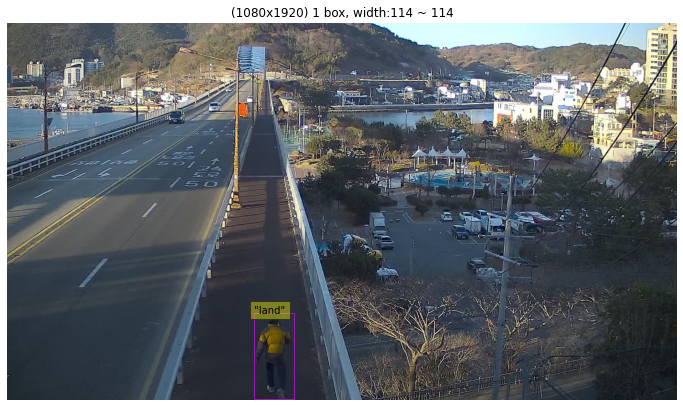

200 [3.]


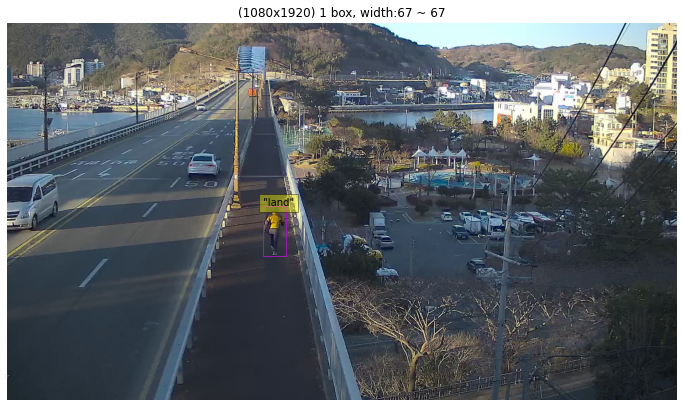

400 [3.]


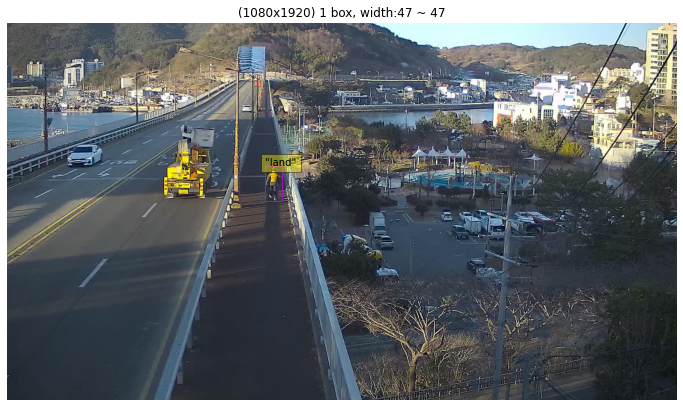

600 [3.]


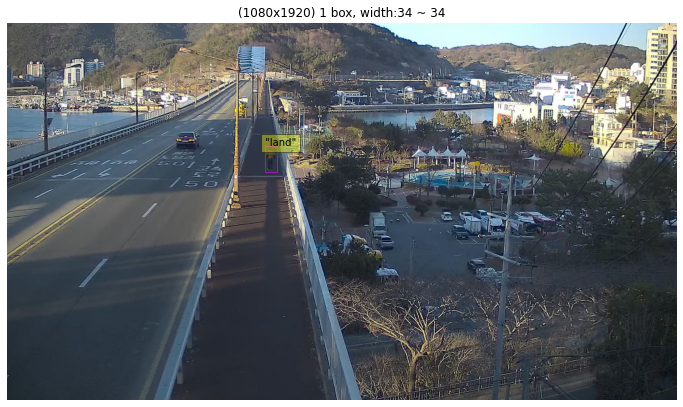

800 [3.]


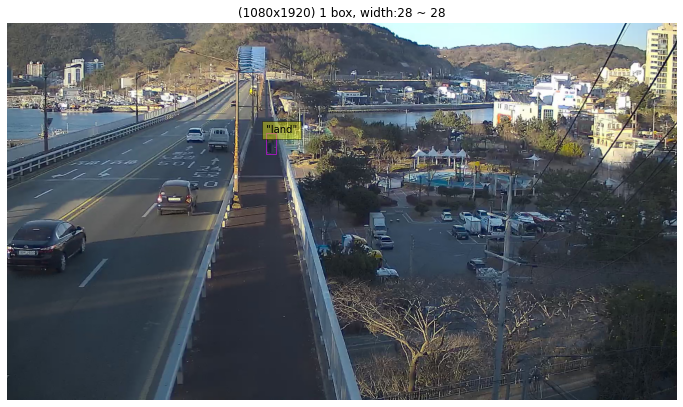

1000 [3.]


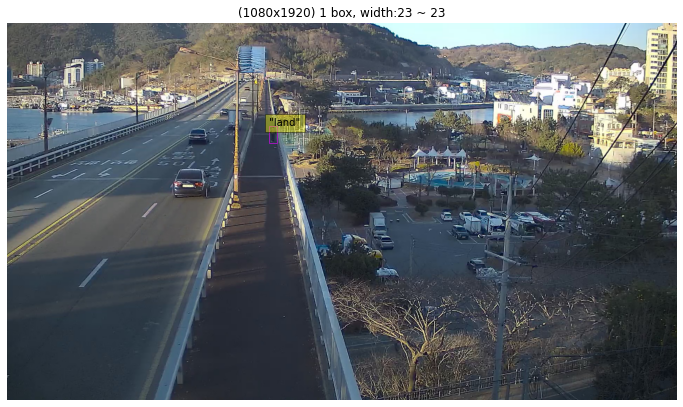

1200 [3.]


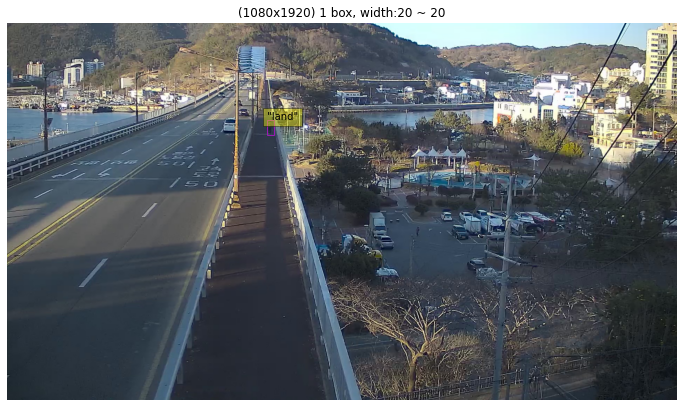

1400 [3.]


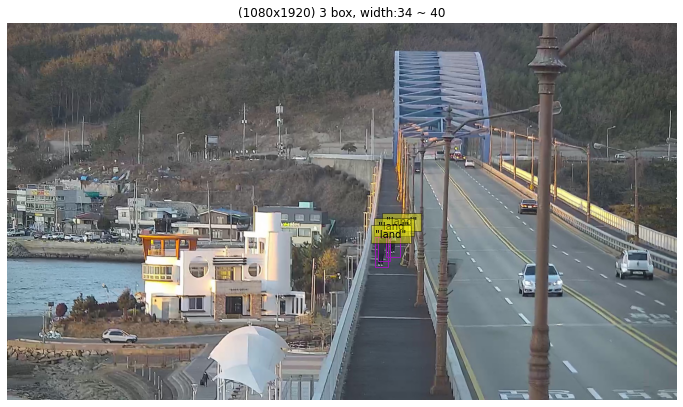

In [137]:
display_data(input_list, bbox_list, stride=200)

In [14]:
def video_to_frames(input_loc, output_loc, stride=1, is_save=True):  
    
    video_file_name = input_loc.split(os.sep)[-1]
    video_file_name = video_file_name.split('.')[-1]
    output_loc = output_loc + video_file_name
    if not os.path.isdir(output_loc):
        try:
            os.mkdir(output_loc)
        except OSError:
            pass    
    
    # Log the time
    time_start = time.time()
    # Start capturing the feed
    cap = cv2.VideoCapture(input_loc)
    # Find the number of frames
    
    video_length = int(cap.get(cv2.CAP_PROP_FRAME_COUNT)) - 1
    print ("Number of frames: ", video_length)
    count = 0
    print ("Converting video.."+video_file_name+" \n")
    # Start converting the video
    
    while cap.isOpened():
        # Extract the frame
        ret, frame = cap.read()
        
        if count % stride == 0:
            # Write the results back to output location.
            if is_save:
                file_name = output_loc +"/%#05d.jpg"  % (count)
                cv2.imwrite(file_name, frame)
                if False:
                    b, g, r = np.split(frame, 3, -1)
                    rgb = np.concatenate((r,g,b), -1)        
                    img = Image.fromarray(rgb)
                    img.save(file_name)
            else:
                plt.imshow(frame[:,:,::-1])
                plt.show()
            
            # If there are no more frames left
        if count%100==0:
            print('count', video_length, count)
        if (count > (video_length-1)):
            # Log the time again
            time_end = time.time()
            # Release the feed
            cap.release()
            # Print stats
            print ("Done extracting frames.\n%d frames extracted" % count)
            print ("It took %d seconds forconversion." % (time_end-time_start))
            break
        count += 1

In [19]:
video_to_frames(paths_avi[0], paths_avi[0], 1, is_save=True)

Number of frames:  15348
Converting video..미수_스마트시티_통영대교_도천방향1(Ch 01)_[20201215]162700-[20201215]163530(20201215_16270_.avi 

count 15348 0
count 15348 100
count 15348 200
count 15348 300
count 15348 400
count 15348 500
count 15348 600
count 15348 700
count 15348 800
count 15348 900
count 15348 1000
count 15348 1100
count 15348 1200
count 15348 1300
count 15348 1400
count 15348 1500
count 15348 1600
count 15348 1700
count 15348 1800
count 15348 1900
count 15348 2000
count 15348 2100
count 15348 2200
count 15348 2300
count 15348 2400
count 15348 2500
count 15348 2600
count 15348 2700
count 15348 2800
count 15348 2900
count 15348 3000
count 15348 3100
count 15348 3200
count 15348 3300
count 15348 3400
count 15348 3500
count 15348 3600
count 15348 3700
count 15348 3800
count 15348 3900
count 15348 4000
count 15348 4100
count 15348 4200
count 15348 4300


KeyboardInterrupt: 